In [ ]:
# supervised machinelearning

In [16]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import sys
import logging
import numpy as np
import string
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn import svm
from datetime import datetime
import os
from gensim.models.word2vec import Word2Vec
import gensim
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from collections import defaultdict

import embeddingvectorizer
from nltk.corpus import stopwords

from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import TfidfTransformer
import json

In [2]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
path_to_data ='../data/'
df = pd.read_pickle(path_to_data + "data_geannoteerd.pkl")
data = df['text']
labels = df['topic']

In [4]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/anne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
text =df['text']
df['text_stop']= df['text'].str.lower()
stop = set(stopwords.words('dutch'))
df['text_stop']= df['text_stop'].str.split()

In [6]:
df['text_stop']= df['text_stop'].apply(lambda x:[ item for item in x if item not in stop ])
df['text_stop']= df['text_stop'].apply(lambda x:' '.join(x))
text_stop = df['text_stop']

In [9]:
df['text_lead'] = df['text_stop']
def proc(s):
    l = s.split()
    return ' '.join(l[:75])
df['text_lead'] =[ proc (s) for s in df['text_lead'].values.tolist() ]
text_lead =df['text_lead']

In [ ]:
df.head()

In [10]:
textcolumns = {'text': text, 'text_stop': text_stop, 'text_lead': text_lead}

In [11]:
results = pd.DataFrame()
gridsearchresults = pd.DataFrame()
DV = 'topic'
y= df[DV].as_matrix()
X= df[textcolumns]
X_train , X_test , y_train , y_test = train_test_split (X, y, test_size =0.2 , random_state =42)
X_train.shape

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


(2788, 3)

In [12]:
results = pd.DataFrame()

In [ ]:
clf_pipeline.fit(X_train['text'], y_train)
preds = clf_pipeline.predict(X_test['text'])

In [ ]:
def classification_report_df (precision, recall, fscore,  report_name):
    report_data =[]
    row = {}
    row['classifier']= report_name
    #row['class']= row_data [0]
    row['precision']= float( precision)
    row['recall']= float(recall)
    row['f1_score']= float(fscore)
    #row['support']= support
    report_data.append(row )
    print(report_data)
    dataframe =pd.DataFrame.from_dict(report_data )
    print(dataframe)
    return dataframe

In [ ]:
def applybestparams(classifier , X_train , X_name , y_train , X_test , y_test , gridsearchresults ):
    bestparams = gridsearchresults [( gridsearchresults.classifier == classifier ) & ( gridsearchresults.textcolumn == X_name )]
    print(bestparams)
    
    bp = bestparams.iloc[0].to_dict()
    
    clf_pipeline = Pipeline([('vect', CountVectorizer() ),
    ("svm", SGDClassifier(loss='hinge', tol=1e-4, penalty=bp['clf__penalty'], alpha=bp['clf__alpha'], max_iter=bp['clf__max_iter'], random_state=42))
    ])
    
    text_clf = clf_pipeline.fit (X_train[X_name], y_train )   
    predicted = text_clf.predict(X_test [ X_name ])
    
    
    precision, recall, fscore, support= score(y_test, predicted, average='macro')
    
    return {'accuracy': test_accuracy, 'precision': test_precision, 'recall':test_recall, 'f1':test_f1score}
    res_apply = classification_report_df (precision, recall, fscore,  'SGD_' + X_name )
    #joblib.dump (text_clf, 'PassiveAggressive_' + X_name + 'string.pkl')

In [19]:
basepath = '/Users/anne/repos/embedding_models/test/'

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.02, random_state=42)


class word2vec_analyzer():
    '''This class tests the efficacy of Word2Vec models in downstream tasks.'''

    def __init__(self):
        self.nmodel = 0
        self.vectorizer = 'Tfidf'
        
       # logger.info("Created analyzer with {} combinations for crime and {} combinations for low life".format(
       #     len(self.combinations_crime), len(self.combinations_low)))

    def get_w2v_model(self):
        '''yields a dict with one item. key is the filename, value the gensim model'''
        
        filenames = [e for e in os.listdir(basepath) if not e.startswith('.')]

        for fname in filenames:
            model = {}
            path = os.path.join(basepath, fname)
            logger.info("\nLoading gensim model")
            mod = gensim.models.Word2Vec.load(path)
            model['gensimmodel'] = dict(zip(mod.wv.index2word, mod.wv.syn0))
            model['filename'] = fname
            #splitResult = fname.split( "_" ) #split on scores
            self.nmodel +=1
            logger.info("loaded gensim model nr {}, named: {}".format(self.nmodel, model['filename']))
            yield model
        
    def get_best_parameters(self):
        
        if self.vectorizer == 'Tfidf':
            pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', SGDClassifier(loss='hinge', tol=1e-4)),
            ])
            
        else:
            pipeline = Pipeline([
                ('vect', CountVectorizer()),
                ('clf', SGDClassifier(loss='hinge', tol=1e-4)),
            ])
            
        param_grid =  {'clf__max_iter': (20, 30) , 'clf__alpha': (0.00001, 0.000001), 'clf__penalty': ('l2', 'elasticnet')}

        search = GridSearchCV(pipeline, param_grid, iid=False, cv=5)
        logger.info("Start GridSearch ...")

        search.fit(X_train, y_train )   

        print("Best parameter (CV score=%0.3f):" % search.best_score_)
        print()
        print("Best parameters:", search.best_params_)

        return search.best_params_
    
    def apply_bestparameters_baseline(self, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
        if self.vectorizer == "Tfidf":
            
            pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', SGDClassifier(loss='hinge', tol=1e-4, penalty=bp['clf__penalty'], alpha=bp['clf__alpha'], max_iter=bp['clf__max_iter'] )),
            ])
            
        else:
            pipeline = Pipeline([
                ('vect', CountVectorizer()),
                ('clf', SGDClassifier(loss='hinge', tol=1e-4, penalty=bp['clf__penalty'], alpha=bp['clf__alpha'], max_iter=bp['clf__max_iter'] )),
            ])

        clf = pipeline.fit(X_train, y_train)   
        logger.info("fitted baseline model...")

        predicted = clf.predict(X_test)
        logger.info("predicted baseline model... ")

        precision, recall, fscore, support= score(y_test, predicted, average='macro')
        
        results.append({'precision': precision, 
        'recall': recall, 
        'f1': fscore, 
        'classifier' : "SGD", 
        'penalty' : bp['clf__penalty'], 
        'alpha' : bp['clf__alpha'], 
        'max_iter' : bp['clf__max_iter'] , 
        'model' : model['filename']})

        return results

    
    def apply_bestparameters_w2v(self, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
        results = []
        bp = self.get_best_parameters()
        
        for model in self.get_w2v_model():
            
            logger.info(">>>> Retrieving best parameter settings for the model {} ...".format(model['filename']))
            if self.vectorizer == "Tfidf":
                logger.info("Apply best parameter setting for the model {} ...".format(model['filename']))

                pipeline = Pipeline([("word2vec Tfidf vectorizer", embeddingvectorizer.EmbeddingTfidfVectorizer(model, operator='mean')),
                                     ("clf", SGDClassifier(loss='hinge', tol=1e-4, penalty=bp['clf__penalty'], alpha=bp['clf__alpha'], max_iter=bp['clf__max_iter']))
                    ])
            else:
                logger.info("Apply best parameter setting for the model {} ...".format(model['filename']))
                pipeline = Pipeline([
                    ("word2vec Count vectorizer", embeddingvectorizer.EmbeddingCountVectorizer(model, operator='mean')),
                    ("clf", SGDClassifier(loss='hinge', tol=1e-4, penalty=bp['clf__penalty'], alpha=bp['clf__alpha'], max_iter=bp['clf__max_iter']))
                ])


            clf = pipeline.fit(X_train, y_train)   
            logger.info("fitted...{} ...".format(model['filename']))

            predicted = clf.predict(X_test)
            logger.info("predicted...{} ...".format(model['filename']))

            precision, recall, fscore, support= score(y_test, predicted, average='macro')

            results.append({'precision': precision, 
                    'recall': recall, 
                    'f1': fscore, 
                    'classifier' : "SGD", 
                    'penalty' : bp['clf__penalty'], 
                    'alpha' : bp['clf__alpha'], 
                    'max_iter' : bp['clf__max_iter'] , 
                    'model' : model['filename']})
            
            return results
        
    def get_final_results(self):
        results_baseline = self.apply_bestparameters_baseline()
        results_w2v = self.apply_bestparameters_w2v()
        return results_baseline + results_w2v

if __name__ == "__main__":

    logger = logging.getLogger()
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')
    logging.root.setLevel(level=logging.INFO)
    
    myanalyzer = word2vec_analyzer()
    my_results = myanalyzer.apply_bestparameters_w2v()
    
    print("\n\n\nSave results\n\n\n")
    with open('output_my_results.json',mode='w') as fo:
        fo.write('[')
        
        for result in my_results:
            #print("this is the result:", result)
            fo.write(json.dumps(result))
            fo.write(',\n')
        fo.write('[]]')

    df = pd.DataFrame.from_dict(my_results)
    print('Created dataframe')
    # print(df)
    df.to_csv('w2v_evaluation.csv')


INFO:root:Start GridSearch for model {} ...
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
INFO:root:
Loading gensim model
INFO:gensim.utils:loading Word2Vec object from /Users/anne/repos/embedding_models/test/w2v_model_nr_0_window_5_size_100_negsample_5


Best parameter (CV score=0.833):

Best parameters: {'clf__alpha': 1e-05, 'clf__max_iter': 30, 'clf__penalty': 'l2'}


INFO:gensim.utils:loaded /Users/anne/repos/embedding_models/test/w2v_model_nr_0_window_5_size_100_negsample_5
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
INFO:root:loaded gensim model nr 1, named: w2v_model_nr_0_window_5_size_100_negsample_5
INFO:root:>>>> Retrieving best parameter settings for the model w2v_model_nr_0_window_5_size_100_negsample_5 ...
INFO:root:Apply best parameter setting for the model w2v_model_nr_0_window_5_size_100_negsample_5 ...
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
INFO:root:fitted...w2v_model_nr_0_window_5_size_100_negsample_5 ...
INFO:root:predicted...w2v_model




Save results





NameError: name 'json' is not defined

In [11]:
myanalyzer = word2vec_analyzer()
results = myanalyzer.apply_bestparameters_w2v()

INFO:root:
Loading gensim model
INFO:gensim.utils:loading Word2Vec object from /Users/anne/repos/embedding_models/test/w2v_model_nr_0_window_5_size_100_negsample_5
INFO:gensim.utils:loaded /Users/anne/repos/embedding_models/test/w2v_model_nr_0_window_5_size_100_negsample_5
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
INFO:root:loaded gensim model nr 1, named: w2v_model_nr_0_window_5_size_100_negsample_5
INFO:root:>>>> Retrieving best parameter settings for the model w2v_model_nr_0_window_5_size_100_negsample_5 ...
INFO:root:Starting gridsearch to optimize parameter setting for model w2v_model_nr_0_window_5_size_100_negsample_5 using TfidfVectorizer ...
INFO:root:Start GridSearch for model w2v_model_nr_0_window_5_size_100_negsample_5 ...
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklear

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration rea

Best parameter (CV score=0.559):

Best parameters: {'clf__alpha': 1e-05, 'clf__max_iter': 30, 'clf__penalty': 'elasticnet'}


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
INFO:root:fitted...w2v_model_nr_0_window_5_size_100_negsample_5 ...
INFO:root:predicted...w2v_model_nr_0_window_5_size_100_negsample_5 ...
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


NameError: name 'vect' is not defined

In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import sys
import logging
import numpy as np
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn import svm
from datetime import datetime
import os

from gensim.models.word2vec import Word2Vec
import gensim

from sklearn.pipeline import Pipeline
from collections import defaultdict

import embeddingvectorizer
from nltk.corpus import stopwords

from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import TfidfTransformer
import json

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

path_to_data ='../data/'
df = pd.read_pickle(path_to_data + "data_geannoteerd.pkl")
data = df['text']
labels = df['topic']

basepath = '/home/anne/tmpanne/fullsample/'

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.02, random_state=42)

class word2vec_analyzer():
    '''This class tests the efficacy of Word2Vec models in downstream tasks.'''

    def __init__(self):
        self.nmodel = 0
        self.vectorizer = 'Tfidf'
        self.param_grid = {'clf__penalty': ('l2', 'elasticnet') }
        
       # logger.info("Created analyzer with {} combinations for crime and {} combinations for low life".format(
       #     len(self.combinations_crime), len(self.combinations_low)))

    def get_w2v_model(self):
        '''yields a dict with one item. key is the filename, value the gensim model'''
        
        filenames = [e for e in os.listdir(basepath) if not e.startswith('.')]

        for fname in filenames:
            model = {}
            path = os.path.join(basepath, fname)
            logger.info("\nLoading gensim model")
            mod = gensim.models.Word2Vec.load(path)
            model['gensimmodel'] = dict(zip(mod.wv.index2word, mod.wv.syn0))
            model['filename'] = fname
            #splitResult = fname.split( "_" ) #split on scores
            self.nmodel +=1
            logger.info("loaded gensim model nr {}, named: {}".format(self.nmodel, model['filename']))
            yield model
        
    def get_best_parameters(self):
        
        results = []
        
        if self.vectorizer == 'Tfidf':
            pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', SGDClassifier(loss='hinge', tol=1e-4, alpha=1e-6, max_iter=1000, random_state=42)),
            ])
            
        else:
            pipeline = Pipeline([
                ('vect', CountVectorizer()),
                ('clf', SGDClassifier(loss='hinge', tol=1e-4, alpha=1e-6, max_iter=1000, random_state=42)),
            ])
            
        param_grid = self.param_grid 
        search = GridSearchCV(pipeline, param_grid, iid=False, cv=5)
        logger.info("Start GridSearch ...")

        search.fit(X_train, y_train )   
      
        print("Best parameter (CV score=%0.3f):" % search.best_score_)
        print()
        print("Best parameters:", search.best_params_)
        

        return search.best_params_ 
    
  
    def apply_bestparameters_w2v(self, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
        
        logger.info("retrieved the best parameter settings: {}...  ".format(bp))
        logger.info("\n\n\nthese are the results of the baseline model with hyperparameter optimalization: {}".format(results_baseline))
        
        results = []
        
        bp = self.get_best_parameters()
        
        if self.vectorizer == "Tfidf":
            
            pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', SGDClassifier(loss='hinge', alpha=1e-6, tol=1e-4, max_iter=1000, random_state=42, penalty=bp['clf__penalty'])
                 )])
            
        else:
            pipeline = Pipeline([
                ('vect', CountVectorizer()),
                ('clf', SGDClassifier(loss='hinge', alpha=1e-6, tol=1e-4, max_iter=1000, random_state=42, penalty=bp['clf__penalty'])
                 )])
            
        clf = pipeline.fit(X_train, y_train)   
        logger.info("fitted baseline model.")

        test_pred = clf.predict(X_test)
        logger.info("predicted baseline model.")
            
        test_pred = search.predict(X_test)
        accuracy = accuracy_score(y_test, test_pred)
        precision = precision_score(y_test, test_pred, average = 'macro')
        recall = recall_score(y_test, test_pred, average = 'macro')
        f1score = f1_score(y_test, test_pred, average = 'macro')
        
        results.append({'accuracy': accuracy, 
            'precision': precision, 
            'recall': recall, 
            'f1score': f1_score, 
            'classifier' : "SGD",
            'model' : 'baseline'})
        
        
        for model in self.get_w2v_model():
            logger.info(">>>> Retrieving best parameter settings for the model {} ...".format(model['filename']))

            
            if self.vectorizer == "Tfidf":
                
                logger.info("Apply best parameter setting for the model {} ...".format(model['filename']))
                pipeline = Pipeline([
                    ("word2vec Tfidf vectorizer", embeddingvectorizer.EmbeddingTfidfVectorizer(model['gensimmodel'], operator='mean')),
                    ("clf", SGDClassifier(loss='hinge', alpha=1e-6, tol=1e-4, max_iter=1000, random_state=42, penalty=bp['clf__penalty']))
                    ])
                
                
                
            else:
                logger.info("Apply best parameter setting for the model {} ...".format(model['filename']))
                pipeline = Pipeline([
                    ("word2vec Count vectorizer", embeddingvectorizer.EmbeddingCountVectorizer(model['gensimmodel'], operator='mean')),
                    ("clf", SGDClassifier(loss='hinge', alpha=1e-6, tol=1e-4, max_iter=1000, random_state=42, penalty=bp['clf__penalty']))
                    ])
                
                
            clf = pipeline.fit(X_train, y_train)   
            logger.info("fitted...{} ...".format(model['filename']))

            test_pred = clf.predict(X_test)
            logger.info("predicted...{} ...".format(model['filename']))

            accuracy = accuracy_score(y_test, test_pred)
            precision = precision_score(y_test, test_pred, average = 'macro')
            recall = recall_score(y_test, test_pred, average = 'macro')
            f1score = f1_score(y_test, test_pred, average = 'macro')

            results.append({'accuracy': accuracy, 
            'precision': precision, 
            'recall': recall, 
            'f1score': f1_score, 
            'classifier' : "SGD",
            'model' : model['filename']})

            print("these are the results of the w2v models:", accuracy, precision, recall)
            
        return results
        
if __name__ == "__main__":

    logger = logging.getLogger()
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')
    logging.root.setLevel(level=logging.INFO)
    
    myanalyzer = word2vec_analyzer()
    my_results = myanalyzer.apply_bestparameters_w2v()
    
    print("\n\n\nSave results\n\n\n")
    with open('output_my_results.json',mode='w') as fo:
        fo.write('[')
        
        for result in my_results:
            #print("this is the result:", result)
            fo.write(json.dumps(result))
            fo.write(',\n')
        fo.write('[]]')

    df = pd.DataFrame.from_dict(my_results)
    print('Created dataframe')
    # print(df)
    df.to_csv('w2v_evaluation.csv')


            


In [ ]:
def get_best_parameters(model = None, Tfidf = False):
    
    if model == None:
        if Tfidf == True:
            pipeline = Pipeline([
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', tol=1e-4)),
            ])

            
        else:
            pipeline = Pipeline([
                ('vect', CountVectorizer()),
                ('clf', SGDClassifier(loss='hinge', tol=1e-4)),
            ])

   
    if model != None:
        if Tfidf == True:
            pipeline = Pipeline([("word2vec Tfidf vectorizer", embeddingvectorizer.EmbeddingTfidfVectorizer(model, operator='mean')),
                                 ("clf", SGDClassifier(loss='hinge', tol=1e-4))
                ])

        if Tfidf == False:
            pipeline = Pipeline([("word2vec Count vectorizer", embeddingvectorizer.EmbeddingCountVectorizer(model, operator='mean')),
                             ("clf", SGDClassifier(loss='hinge', tol=1e-4))
            ])
   
    param_grid =  {'clf__max_iter': (20, 1000, 5000) , 'clf__alpha': (0.00001, 0.000001), 'clf__penalty': ('l2', 'elasticnet')}

    
    search = GridSearchCV(pipeline, param_grid, iid=False, cv=5)
    search.fit(X_train, y_train )   

    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print()
    print("Best parameters:", search.best_params_)
    
    return search.best_params_

In [ ]:
def apply_bestparameters(X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, model = "baseline", vect = "Tfidf"):
    
   # bp = get_best_parameters()
    bp = {'clf__alpha': 1e-06, 'clf__max_iter': 1000, 'clf__penalty': 'elasticnet'}
    
    if model == "baseline":
        if vect == "Tfidf":
            
            pipeline = Pipeline([
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', tol=1e-4, penalty=bp['clf__penalty'], alpha=bp['clf__alpha'], max_iter=bp['clf__max_iter'] )),
            ])
            
        else:
            pipeline = Pipeline([
                ('vect', CountVectorizer()),
                ('clf', SGDClassifier(loss='hinge', tol=1e-4, penalty=bp['clf__penalty'], alpha=bp['clf__alpha'], max_iter=bp['clf__max_iter'] )),
            ])
            
            
    if model != "baseline":
        if vect == "Tfidf":
            
            pipeline = Pipeline([("word2vec Tfidf vectorizer", embeddingvectorizer.EmbeddingTfidfVectorizer(model, operator='mean')),
                                 ("clf", SGDClassifier(loss='hinge', tol=1e-4, penalty=bp['clf__penalty'], alpha=bp['clf__alpha'], max_iter=bp['clf__max_iter']))
                ])

               
        else:
            pipeline = Pipeline([
                ("word2vec Count vectorizer", embeddingvectorizer.EmbeddingCountVectorizer(model, operator='mean')),
                ("clf", SGDClassifier(loss='hinge', tol=1e-4, penalty=bp['clf__penalty'], alpha=bp['clf__alpha'], max_iter=bp['clf__max_iter']))
            ])
   

    clf = pipeline.fit(X_train, y_train)   
    predicted = clf.predict(X_test)
    
    precision, recall, fscore, support= score(y_test, predicted, average='macro')
    
    return {'precision': precision, 
            'recall': recall, 
            'f1': fscore, 
            'classifier' : "SGD", 
            'penalty' : bp['clf__penalty'], 
            'alpha' : bp['clf__alpha'], 
            'max_iter' : bp['clf__max_iter'] , 
            'vectorizer' : vect , 
            'model' : model}
            

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.02, random_state=42)

In [ ]:
apply_bestparameters(vect = "Tfidf", model = "baseline")

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.02, random_state=0)
get_best_parameters(Tfidf = False, model = aem_320d)

In [ ]:
get_best_parameters(Tfidf = True)

In [ ]:
for model in models:
    res_apply = applybestparams(model, X_train, textcol, y_train, X_test, y_test, gridsearchresults)
    print("res_apply", res_apply)
    results = results.append(res_apply)

In [ ]:
classification_report_df

In [ ]:
print("\nLoading aem_320d model")

mod = gensim.models.Word2Vec.load(path_to_models + 'w2v_320d')
aem_320d = dict(zip(mod.wv.index2word, mod.wv.syn0))

In [82]:
print("\nLoading aem_300d model")

mod = gensim.models.Word2Vec.load('/Users/anne/repos/embedding_models/w2v_model_nr_7_window_10_size_300_negsample_15')
aem_300d = {w: vec for w, vec in zip(mod.wv.index2word, mod.wv.syn0)}

INFO:gensim.utils:loading Word2Vec object from /Users/anne/repos/embedding_models/w2v_model_nr_7_window_10_size_300_negsample_15



Loading aem_300d model


INFO:gensim.utils:loaded /Users/anne/repos/embedding_models/w2v_model_nr_7_window_10_size_300_negsample_15
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  after removing the cwd from sys.path.


In [ ]:
print("\nLoading wiki model")

model = gensim.models.KeyedVectors.load_word2vec_format(path_to_models + 'wiki.nl.vec')
wiki = dict(zip(model.wv.index2word, model.wv.syn0))


In [ ]:
print("\nLoading cow model")

model = gensim.models.KeyedVectors.load_word2vec_format(path_to_models + 'cow-big.txt', binary=False)
cow = dict(zip(model.wv.index2word, model.wv.syn0))


pipeline: "Sequentially apply a list of transforms and a final estimator. Intermediate steps of pipeline must implement fit and transform methods and the final estimator only needs to implement fit."

https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976


In [ ]:
etree_aem_320d_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(aem_320d))])
etree_aem_320d_mean = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(aem_320d))])

etree_aem_300d_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(aem_300d))])
etree_aem_300d_mean = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(aem_300d))]) 

etree_wiki_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(wiki))])
etree_wiki_mean = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(wiki))]) 

etree_cow_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(cow))])
etree_cow_mean = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(cow))]) 


In [23]:
etree_aem_320d_tfidf = Pipeline([("word2vec vectorizer", embeddingvectorizer(aem_300d))])
etree_aem_320d_mean = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(aem_300d))])

NameError: name 'TfidfEmbeddingVectorizer' is not defined

In [ ]:
p = Pipeline([("word2vec vectorizer", embeddingvectorizer.EmbeddingCountVectorizer(aem_320d, 'mean'))])
d = p.fit_transform(data)
d.shape

In [ ]:
pipe_aem_320d = Pipeline([
    ("word2vec vectorizer", embeddingvectorizer.EmbeddingCountVectorizer(aem_320d, 'mean')),
    ("svm", SGDClassifier(loss='hinge', penalty='l2', tol=1e-4, alpha=1e-6, max_iter=1000, random_state=42))
    ])

In [39]:
pipe_aem_300d = Pipeline([
    ("word2vec vectorizer", embeddingvectorizer.EmbeddingTfidfVectorizer(aem_300d, 'mean')),
    ("svm", SGDClassifier(loss='hinge', penalty='l2', tol=1e-4, alpha=1e-6, max_iter=1000, random_state=42))
    ])

In [ ]:
clf_pipeline = Pipeline([('vect', CountVectorizer() ),
    ("svm", SGDClassifier(loss='hinge', penalty='l2', tol=1e-4, alpha=1e-6, max_iter=1000, random_state=42))
    ])

In [ ]:
from pprint import pprint
from time import time
import logging

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


# Uncomment the following to do the analysis on all the categories
#categories = None


# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(tol=1e-3)),
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, cv=5,
                               n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [40]:
clf_pipeline.fit(X_train, y_train)
preds = clf_pipeline.predict(X_test)
#confusion_matrix(y_test, preds)

NameError: name 'clf_pipeline' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
logistic = SGDClassifier(loss='log', penalty='l2', early_stopping=True, max_iter=10000, tol=1e-5, random_state=0)

pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

#digits = datasets.load_digits()
X_digits = X_train
y_digits = y_train

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [5, 20, 30, 40, 50, 64],
    'logistic__alpha': np.logspace(-4, 4, 5),
}
search = GridSearchCV(pipe, param_grid, iid=False, cv=5)

search.fit(X_digits, y_digits)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X_digits)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')

In [ ]:
print(len(aem_320d))

In [ ]:
sklearn.metrics.accuracy_score(y_test,preds)

In [ ]:
pipe_aem_320d_tfidf_svm = Pipeline([
    ("word2vec Count vectorizer", embeddingvectorizer.EmbeddingCountVectorizer(aem_320d, operator='mean')),
    ("svm", SGDClassifier(loss='hinge', penalty='l2', tol=1e-4, alpha=1e-6, max_iter=1000, random_state=42))
    ])

In [ ]:
parameters = {}
parameters['imp__strategy'] = ['mean', 'median', 'most_frequent']
parameters['feat_select__k'] = [5, 10]

CV = GridSearchCV(pipeline, parameters, scoring = 'mean_absolute_error', n_jobs= 1)
CV.fit(x_train_cont, y_train)   

print('Best score and parameter combination = ')

In [25]:
pipe_aem_300d_tfidf_svm = Pipeline([
    ("word2vec Count vectorizer", embeddingvectorizer.EmbeddingTfidfVectorizer(aem_300d, operator='mean')),
    ("svm", SGDClassifier(loss='hinge', penalty='l2', tol=1e-4, alpha=1e-6, max_iter=1000, random_state=42))
    ])

In [ ]:
pipe_normal_svm = Pipeline([
    ("vectorizer", embeddingvectorizer.EmbeddingTfidfVectorizer(aem_320d, operator='mean')),
    ("svm", SGDClassifier(loss='hinge', penalty='l2', tol=1e-4, alpha=1e-6, max_iter=1000, random_state=42))
    ])

In [50]:
pipe_aem_300d_count_svm = Pipeline([
    ("word2vec Count vectorizer", embeddingvectorizer.EmbeddingCountVectorizer(aem_300d, operator='mean')),
    ("svm", SGDClassifier(loss='hinge', penalty='elasticnet', tol=1e-4, alpha=1e-6, max_iter=5000, random_state=42))
    ])

In [54]:
pipe_count_svm = Pipeline([
    ("vect", CountVectorizer()),
    ("svm", SGDClassifier(loss='hinge', penalty='elasticnet', tol=1e-4, alpha=1e-6, max_iter=5000, random_state=42))
    ])

In [65]:
pipe_tfidf_svm = Pipeline([
    ("vect", TfidfVectorizer()),
    ("svm", SGDClassifier(loss='hinge', penalty='elasticnet', tol=1e-4, alpha=1e-6, max_iter=5000, random_state=42))
    ])


In [68]:
param_grid ={'clf__max_iter': (1000, 5000) , 'clf__alpha': (0.00001, 0.000001), 'clf__penalty': ('l2', 'elasticnet')}
search = GridSearchCV(pipe_aem_300d_tfidf_svm, param_grid, iid=False, cv=5)
search.fit(X_train, y_train ) 

ValueError: Invalid parameter clf for estimator Pipeline(memory=None,
     steps=[('word2vec Count vectorizer', EmbeddingTfidfVectorizer(operator=<Operator.mean: 'mean'>,
             word2vec={'de': array([ 4.85867, -2.41003, ...,  1.81039,  2.77538], dtype=float32), 'van': array([ 1.21925,  3.80268, ..., -0.93307,  0.42656], dtype=float32), 'het': array([-3.10609,  3.634...m_state=42, shuffle=True, tol=0.0001,
       validation_fraction=0.1, verbose=0, warm_start=False))]). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print()
print("Best parameters:", search.best_params_)

In [217]:


X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.5, random_state=42)
len(X_train)



1743

In [264]:
aem_300d_tfidf_svm = Pipeline([
    ("word2vec TfidF vectorizer", embeddingvectorizer.EmbeddingTfidfVectorizer(aem_300d)),
    ("svm", SGDClassifier(loss='hinge', tol=1e-4, alpha=1e-6, max_iter=5000, random_state=42, penalty='elasticnet'))
    ])

In [265]:
aem_300d_count_svm = Pipeline([
    ("word2vec Count vectorizer", embeddingvectorizer.EmbeddingCountVectorizer(aem_300d)),
    ("svm", SGDClassifier(loss='hinge', tol=1e-4, alpha=1e-6, max_iter=5000, random_state=42, penalty='elasticnet'))
    ])

In [266]:
tfidf_svm = Pipeline([
    ("vect", TfidfVectorizer()),
    ("svm", SGDClassifier(loss='hinge', penalty='elasticnet', tol=1e-4, alpha=1e-6, max_iter=5000, random_state=42))
    ])



In [312]:
count_svm = Pipeline([
    ("vect", CountVectorizer()),
    ("svm", SGDClassifier(loss='hinge', penalty='elasticnet', tol=1e-4, alpha=1e-6, max_iter=5000, random_state=42))
    ])



In [318]:
from sklearn.metrics import precision_recall_fscore_support as score

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.02, random_state=42)
predicted_svm = count_svm.fit(X_train, y_train).predict(X_test)
precision_svm, recall_svm, fscore_svm , support_svm = score(y_test, predicted_svm, average='macro')


In [334]:
aem_300d_count_ET = Pipeline([
    ("word2vec Count vectorizer", embeddingvectorizer.EmbeddingCountVectorizer(aem_300d)),
    ("ExtraTrees", ExtraTreesClassifier(n_estimators=200))
    ])


In [335]:
tfidf_ET = Pipeline([
    ("vect", TfidfVectorizer()),
    ("ExtraTrees", ExtraTreesClassifier(n_estimators=200))
    ])


In [336]:
all_models = [
("aem_300d_count_svm" , aem_300d_count_svm ) ,
("tfidf_ET" , tfidf_ET ) ,


]


In [337]:
all_models

[('aem_300d_count_svm', Pipeline(memory=None,
       steps=[('word2vec Count vectorizer', EmbeddingCountVectorizer(operator=<Operator.mean: 'mean'>,
               word2vec={'de': array([ 4.85867, -2.41003, ...,  1.81039,  2.77538], dtype=float32), 'van': array([ 1.21925,  3.80268, ..., -0.93307,  0.42656], dtype=float32), 'het': array([-3.10609,  3.634...m_state=42, shuffle=True, tol=0.0001,
         validation_fraction=0.1, verbose=0, warm_start=False))])),
 ('tfidf_ET', Pipeline(memory=None,
       steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=1.0, max_features=None, min_df=1,
          ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...tors=200, n_jobs=None,
             oob_score=False, random_state=None, verbose=0, warm_start=False))]))]

In [271]:
count_ET = Pipeline([
    ("vect", CountVectorizer()),
    ("ExtraTrees", ExtraTreesClassifier(n_estimators=200))
    ])


In [273]:
from sklearn.model_selection import cross_val_score
import seaborn as sns

all_models = [
("aem_300d_tfidf_svm" , aem_300d_tfidf_svm ) ,
("aem_300d_count_svm" , aem_300d_count_svm ) , 
("tfidf_svm" , tfidf_svm ),
("count_svm" , count_svm ) ,
("aem_300d_tfidf_ET" , aem_300d_tfidf_ET ) , 
("aem_300d_count_ET" , aem_300d_count_ET ) ,
("tfidf_ET" , tfidf_ET ) ,
("count_ET" ,  count_ET ),

]

unsorted_scores = [(name, cross_val_score(model, data, labels, cv=5).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])


In [340]:
for i in scores:
    print(i[1])

0.8281632178706648
0.8238701449845596


In [ ]:
from sklearn.model_selection import cross_val_score
import seaborn as sns

all_models = [
("aem_300d_tfidf_svm" , aem_300d_tfidf_svm ) ,
("tfidf_svm" , tfidf_svm ),

]

unsorted_scores = [(name, cross_val_score(model, data, labels, cv=5, scoring = "f1").mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])


In [322]:
from tabulate import tabulate
from sklearn.model_selection import StratifiedShuffleSplit

print (tabulate(scores, floatfmt=".4f", headers=("model", 'score')))

model                 score
------------------  -------
tfidf_svm            0.8282
aem_300d_tfidf_svm   0.8239


In [288]:
def benchmark(model, X, y, n):
    test_size = 1 - (n / float(len(y)))
    print("test size: {}".format(test_size))
    scores = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    scores.append(accuracy_score(model.fit(X_train, y_train).predict(X_test), y_test))
    print("mean scores: {}".format(np.mean(scores)))
    return np.mean(scores)


In [289]:
train_sizes = [10, 40, 160, 640, 1000, 3000] 
table = []
for name, model in all_models:
    for n in train_sizes:
        print(name)
        table.append({'model': name, 
                      'accuracy': benchmark(model, data, labels, n), 
                      'train_size': n})
df = pd.DataFrame(table)



aem_300d_tfidf_svm
test size: 0.9971313826735514
mean scores: 0.619102416570771
aem_300d_tfidf_svm
test size: 0.9885255306942053
mean scores: 0.6744051073708648
aem_300d_tfidf_svm
test size: 0.9541021227768216
mean scores: 0.7844257366205653
aem_300d_tfidf_svm
test size: 0.8164084911072863
mean scores: 0.7969079409697821
aem_300d_tfidf_svm
test size: 0.7131382673551347
mean scores: 0.7920353982300885
aem_300d_tfidf_svm
test size: 0.13941480206540446
mean scores: 0.7674897119341564
aem_300d_count_svm
test size: 0.9971313826735514
mean scores: 0.5514959723820483
aem_300d_count_svm
test size: 0.9885255306942053
mean scores: 0.7254788160185722
aem_300d_count_svm
test size: 0.9541021227768216
mean scores: 0.6476247745039087
aem_300d_count_svm
test size: 0.8164084911072863
mean scores: 0.7895291637385805
aem_300d_count_svm
test size: 0.7131382673551347
mean scores: 0.7827835880933226
aem_300d_count_svm
test size: 0.13941480206540446
mean scores: 0.7695473251028807
tfidf_svm
test size: 0.9971

In [245]:
df.model.unique()

array(['aem_300d_et', 'tfidf_et', 'svm', 'aem_300d_tfidf'], dtype=object)

<IPython.core.display.Javascript object>


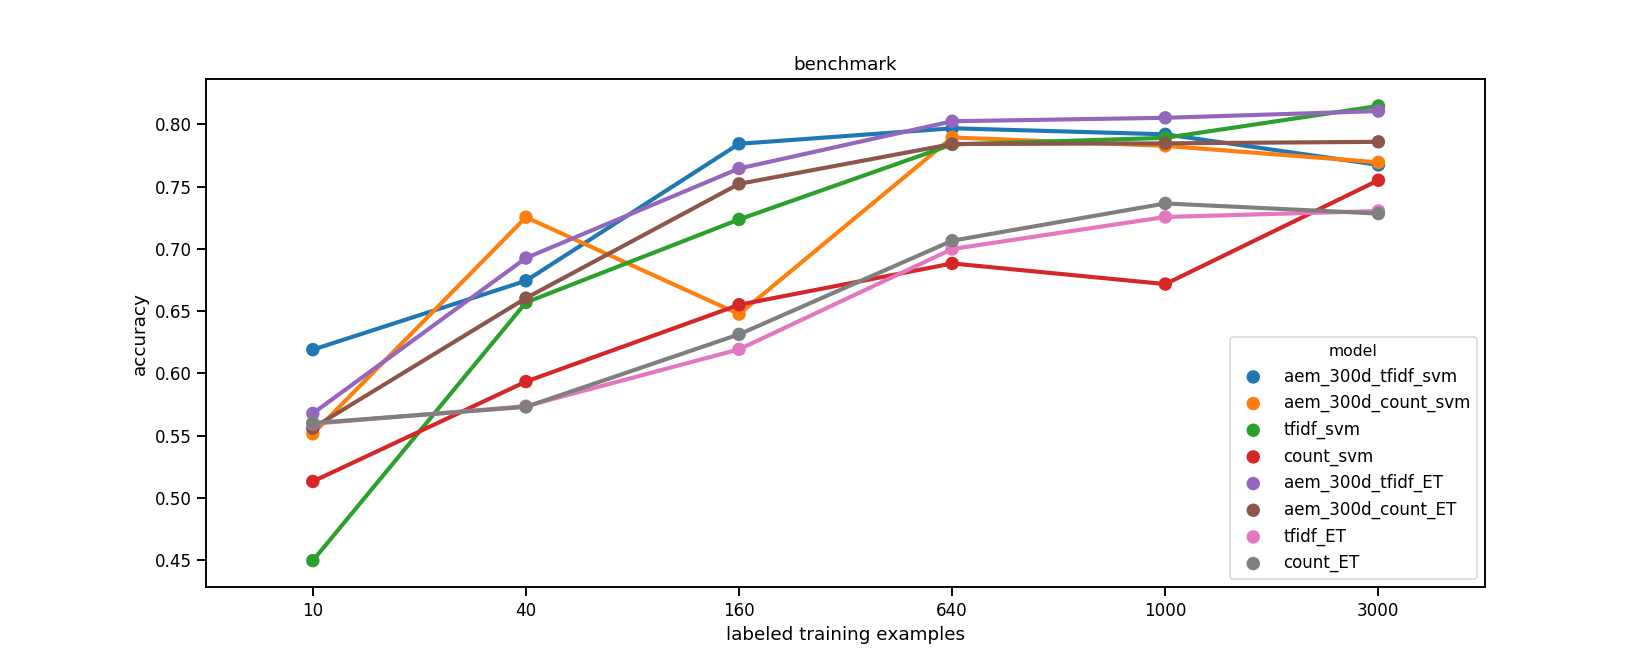

In [292]:
plt.figure(figsize=(15, 6))
fig = sns.pointplot(x='train_size', y='accuracy', hue='model', 
                    data=df[df.model.map(lambda x: x in ["aem_300d_tfidf_svm" ,
                                                         "aem_300d_count_svm" , 
                                                         "tfidf_svm" , 
                                                         "count_svm" , 
                                                         "aem_300d_tfidf_ET" ,
                                                         "aem_300d_count_ET" , 
                                                         "tfidf_ET" ,  
                                                         "count_ET" ,
                                                        ])])
#sns.set_context("notebook", font_scale=1)
fig.set(ylabel="accuracy")
fig.set(xlabel="labeled training examples")
fig.set(title="benchmark")
fig.set(ylabel="accuracy")
plt.savefig("benchmark.png")


In [324]:
pipe_aem_300d_count_svm.fit(X_train, y_train)
preds = pipe_aem_300d_count_svm.predict(X_test)

0.8285714285714286

In [328]:
f1_score(y_test, preds, average = 'micro')

0.8285714285714286

In [ ]:
clf_pipeline.fit(X_train, y_train)
preds = clf_pipeline.predict(X_test)

In [ ]:
pipe_aem_300d_tfidf_svm.fit(X_train, y_train)
preds = pipe_aem_300d_tfidf_svm.predict(X_test)
confusion_matrix(y_test, preds)

In [ ]:
pipe_aem_300d_tfidf_svm.fit(X_train, y_train)
preds = pipe_aem_300d_tfidf_svm.predict(X_test)

0.8428571428571429

In [ ]:
import sklearn.metrics

In [ ]:
sklearn.metrics.accuracy_score(y_test,preds)

In [ ]:
sklearn.metrics.auc(y_test,preds)

In [ ]:
fit_aem_320d = etree_aem_320d_tfidf.fit_transform([x.split() for x in data], labels)


In [ ]:
fit_aem_300d = etree_aem_300d_tfidf.fit_transform([x.split() for x in data], labels)


In [ ]:
fit_wiki = etree_wiki_tfidf.fit_transform([x.split() for x in data], labels)


In [ ]:
fit_cow = etree_cow_tfidf.fit_transform([x.split() for x in data], labels)

In [ ]:
def fit_score(fit_object, data, labels):
    logger.info('{} x entries and {} y entries'.format(fit_object.shape[0], len(labels )))
    X_train, X_test, y_train, y_test = train_test_split(fit_object, labels, test_size=0.2, shuffle = True, random_state=42)
    fit_model =  SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, max_iter=1000, random_state=42).fit(X_train, y_train)
    test_pred = fit_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_pred)
    test_precision = precision_score(y_test, test_pred, average = 'macro')
    test_recall = recall_score(y_test, test_pred, average = 'macro')
    test_f1score = f1_score(y_test, test_pred, average = 'macro')
    return {'accuracy':test_accuracy, 'precision':test_precision, 'recall':test_recall, 'f1':test_f1score}

In [ ]:
evaluation_data = {}
evaluation_data['aem_320d'] = [fit_score(fit_aem_320d, data, labels)]
evaluation_data['aem_300d'] = [fit_score(fit_aem_300d, data, labels)]
evaluation_data['wiki'] = [fit_score(fit_wiki, data, labels)]
evaluation_data['cow'] = [fit_score(fit_cow, data, labels)]

In [ ]:
vectorizer = TfidfVectorizer()

fitted = vectorizer.fit_transform(data, labels)
vocab = np.array(vectorizer.get_feature_names())

logger.info('{} x entries and {} y entries'.format(fitted.shape[0], len(labels )))
X_train, X_test, y_train, y_test = train_test_split(fitted, labels, test_size=0.2, shuffle = True, random_state=42)
fit_model =  SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, max_iter=1000, random_state=42).fit(X_train, y_train)

test_pred = fit_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_pred)
test_precision = precision_score(y_test, test_pred, average = 'macro')
test_recall = recall_score(y_test, test_pred, average = 'macro')
test_f1score = f1_score(y_test, test_pred, average = 'macro')

evaluation_data['normal_ml'] = ({'accuracy': test_accuracy, 'precision':test_precision, 'recall':test_recall, 'f1':test_f1score})

In [333]:
w2v_svm = Pipeline([("word2vec TfidF vectorizer", embeddingvectorizer.EmbeddingCountVectorizer(300d)),("svm", SGDClassifier(loss='hinge', tol=1e-4, alpha=1e-6, max_iter=5000, random_state=42, penalty='elasticnet'))])

w2v_ET = Pipeline([
("word2vec tfidf vectorizer", embeddingvectorizer.EmbeddingCountVectorizer(model['gensimmodel'])), 
("ExtraTrees", ExtraTreesClassifier(n_estimators=200))
])

all_models = [ ( "w2v_svm" , w2v_svm ) , ("w2v_ET ", w2v_ET ), ]


SyntaxError: invalid syntax (<ipython-input-333-7b4626ded4ea>, line 1)

In [ ]:
from typing import Iterable
import numpy as np
from scipy.sparse import spmatrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


class BaseEmbeddingVectorizerMixin:
    """
    Base class for Embedding vectorizer
    Note that we implement this as vectorizer rather than transformer because we need to access the vocabulary.
    """

    def fit_transform(self, X: Iterable[str], y=None):
        x = super().fit_transform(X, y).tocsr()
        return np.array(list(self._transform(x)))
    
    def transform(self, X: Iterable[str], y=None):
        x = super().transform(X, y).tocsr()
        return np.array(list(self._transform(x)))

    def _transform(self, x):
        dim = len(next(iter(self.word2vec.values())))
        voca = self._get_words()
        for doc in range(len(x.indptr) - 1):
            weights = x.data[x.indptr[doc]:x.indptr[doc + 1]]
            words = x.indices[x.indptr[doc]:x.indptr[doc + 1]]

            
            vec = [self.word2vec[voca[w]] * np.array(weights[i])
                   for i, w in enumerate(words) if voca[w] in self.word2vec]
            yield np.mean(vec, axis=0) if vec else np.zeros(dim)

    def _get_words(self):
        # pretty ugly!
        result = [None] * len(self.vocabulary_)
        for w, i in self.vocabulary_.items():
            result[i] = w
        return result


class EmbeddingCountVectorizer(BaseEmbeddingVectorizerMixin, CountVectorizer):
    def __init__(self, word2vec, dim=320, **kargs):
        # WvA: apparently we should enumerate all arguments rather than use **kargs,
        # e.g. https://github.com/scikit-learn/scikit-learn/blob/7389dba/sklearn/feature_extraction/text.py#L1493-L1509
        super().__init__(**kargs)
        self.word2vec = word2vec


class EmbeddingTfidfVectorizer(BaseEmbeddingVectorizerMixin, TfidfVectorizer):
    def __init__(self, word2vec, dim=320, **kargs):
        # WvA: apparently we should enumerate all arguments rather than use **kargs,
        # e.g. https://github.com/scikit-learn/scikit-learn/blob/7389dba/sklearn/feature_extraction/text.py#L1493-L1509
        super().__init__(**kargs)
        self.word2vec = word2vec

In [ ]:

texts = ["dit is een text", "en dit is een kat", "en dit is een langere zin met heel veel woorden erin", "wie?"]
model = {"dit": [3, 0, 0], "kat": [0, 1, 0], "woorden": [0, 0, 1]}
v = EmbeddingTfidfVectorizer(aem_320d, 3)
v.fit_transform(texts)


In [ ]:
labels

# More comparisons

In [ ]:
from tabulate import tabulate
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from gensim.models.word2vec import Word2Vec
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit 

In [ ]:
path_to_data ='../data/'
df = pd.read_pickle(path_to_data + "data_geannoteerd.pkl")

X, y = [], []
X, y = np.array(df['text']), np.array(df['topic'])
print ("total examples %s" % len(y))

In [ ]:
mult_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
mult_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
# SVM - which is supposed to be more or less state of the art 
# http://www.cs.cornell.edu/people/tj/publications/joachims_98a.pdf
etree_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

In [ ]:
all_models = [
    ("mult_nb", mult_nb),
    ("mult_nb_tfidf", mult_nb_tfidf),
    ("bern_nb", bern_nb),
    ("bern_nb_tfidf", bern_nb_tfidf),
    ("w2v", etree_w2v),
    ("w2v_tfidf", etree_w2v_tfidf),
]

unsorted_scores = [(name, cross_val_score(model, X, y, cv=5).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])

print(tabulate(scores, floatfmt=".4f", headers=("model", 'score')))

In [ ]:
import sklearn.model_selection
sklearn.model_selection._fit_and_score??

In [ ]:
plt.figure(figsize=(15, 6))
sns.barplot(x=[name for name, _ in scores], y=[score for _, score in scores])